#    Reversible Jump Markov Chain Monte Carlo (RJMC) between three Lennard-Jonesian models for ethane. 
    The first model, LJ, is a single-site Lennard-Jones fluid.
    The second model, UA, is a two-site Lennard-Jones fluid with the sites separated by the C-C bond length.
    The third model, AUA, is a two-site Lennard-Jones fluid with the sites separated by an extended bond length
    to account for the hydrogens.
    The target properties are saturated liquid density and vapor pressure.

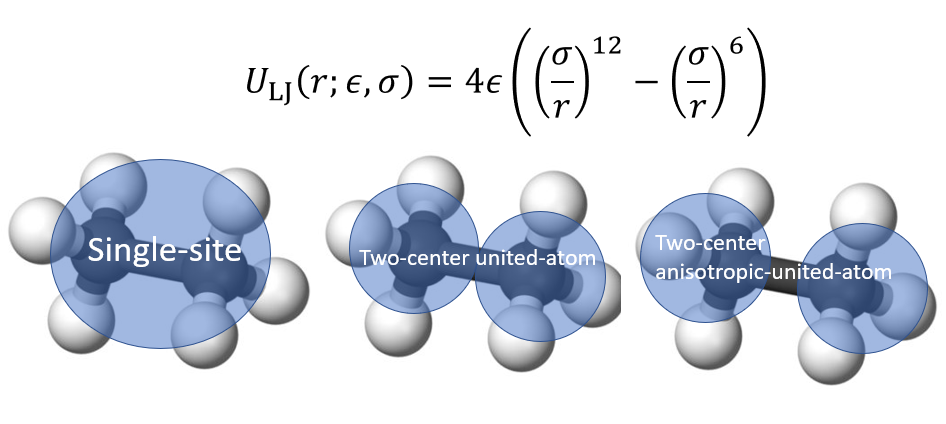

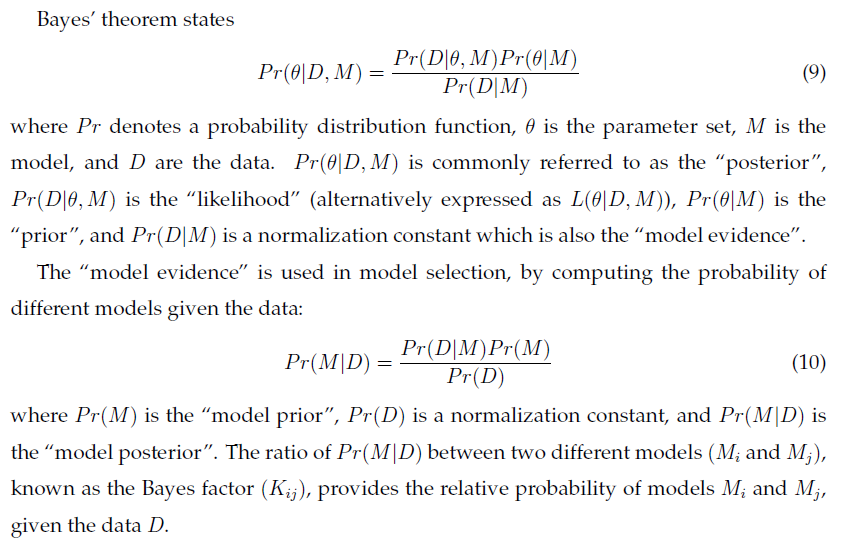

In [1]:
### Import necessary modules

from __future__ import division
import numpy as np
import scipy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from LennardJones_correlations import LennardJones
from LennardJones_2Center_correlations import LennardJones_2C
from scipy.stats import distributions
from scipy.stats import linregress
from scipy.optimize import minimize
import random as rm

In [2]:
# Here we have chosen ethane as the test case
compound="ethane"
fname = compound+".yaml"

In [3]:
# Load property values for compound

with open(fname) as yfile:
    yfile = yaml.load(yfile)

# Force field parameters
eps_lit_LJ = yfile["force_field_params"]["eps_lit_LJ"] #[K]
sig_lit_LJ = yfile["force_field_params"]["sig_lit_LJ"] #[nm]
eps_lit_UA = yfile["force_field_params"]["eps_lit_UA"] #[K]
sig_lit_UA = yfile["force_field_params"]["sig_lit_UA"] #[nm]
Lbond_lit_UA = yfile["force_field_params"]["Lbond_lit_UA"] #[nm]
eps_lit_AUA = yfile["force_field_params"]["eps_lit_AUA"] #[K]
sig_lit_AUA = yfile["force_field_params"]["sig_lit_AUA"] #[nm]
Lbond_lit_AUA = yfile["force_field_params"]["Lbond_lit_AUA"] #[nm]

# Physical constants
Tc_RP = yfile["physical_constants"]["T_c"] #[K]
rhoc_RP = yfile["physical_constants"]["rho_c"] #[kg/m3]
M_w = yfile["physical_constants"]["M_w"] #[gm/mol]

In [4]:
# Substantiate LennardJones class
Ethane_LJ = LennardJones(M_w) # Single-site LJ
Ethane_2CLJ = LennardJones_2C(M_w) #Two-site LJ

In [5]:
# Create functions that return properties for a given model, eps, sig
# Three models are of varying model complexity:
# Simplest model (0): Single-site Lennard-Jones
# Middle complexity model (1): Two-center united-atom Lennard-Jones
# Most complex model (2): Two-center anisotropic-united-atom Lennard-Jones

# rhol is saturated liquid density
# Surrogate models needed to reduce computational burden of performing molecular simulations

def rhol_hat_models(Temp,model,eps,sig):
    
    if model == 0: #Single site LJ

        rhol_hat = Ethane_LJ.rhol_hat_LJ(Temp,eps,sig)
        
    elif model == 1: #Two center UA LJ

        rhol_hat = Ethane_2CLJ.rhol_hat_2CLJQ(Temp,eps,sig,Lbond_lit_UA,0) 

    elif model == 2: #Two center AUA LJ
    
        rhol_hat = Ethane_2CLJ.rhol_hat_2CLJQ(Temp,eps,sig,Lbond_lit_AUA,0) 
    
    return rhol_hat #[kg/m3]       


In [6]:
# Psat is saturation vapor pressure
# Surrogate models

def Psat_hat_models(Temp,model,eps,sig):
    
    if model == 0: #Single site LJ

        Psat_hat = Ethane_LJ.Psat_hat_LJ(Temp,eps,sig)
        
    elif model == 1: #Two center UA LJ

        Psat_hat = Ethane_2CLJ.Psat_hat_2CLJQ(Temp,eps,sig,Lbond_lit_UA,0) 

    elif model == 2: #Two center AUA LJ
    
        Psat_hat = Ethane_2CLJ.Psat_hat_2CLJQ(Temp,eps,sig,Lbond_lit_AUA,0) 
            
    return Psat_hat #[kPa]       


In [7]:
# Load TRC experimental data from file
# Including enthalpy of vaporization for single-site LJ case

data = np.loadtxt('TRC_data_rhoL.txt')
T_rhol_data = data[:,0] #[K]
rhol_data = data[:,1] #[kJ/mol]

data = np.loadtxt('TRC_data_Pv.txt')
T_Psat_data = data[:,0] #[K]
Psat_data = data[:,1] #[kJ/mol]

data = np.loadtxt('TRC_deltaHv.txt')
T_deltaHv = data[:,0] #[K]
RP_deltaHv = data[:,1] #[kJ/mol]

In [8]:
# Limit temperature range to that for which the rhol and Psat surrogate models are reliable

T_min = 137
T_max = 260

T_min = 0
T_max = 290

rhol_data = rhol_data[T_rhol_data>T_min]
T_rhol_data = T_rhol_data[T_rhol_data>T_min]
rhol_data = rhol_data[T_rhol_data<T_max]
T_rhol_data = T_rhol_data[T_rhol_data<T_max]

Psat_data = Psat_data[T_Psat_data>T_min]
T_Psat_data = T_Psat_data[T_Psat_data>T_min]
Psat_data = Psat_data[T_Psat_data<T_max]
T_Psat_data = T_Psat_data[T_Psat_data<T_max]


In [9]:
# Set percent uncertainty in each property
# These values are to represent the simulation uncertainty more than the experimental uncertainty
# Also, the transiton matrix for eps and sig for each model are tuned to this rhol uncertainty.
# I.e. the optimal "lit" values agree well with a 3% uncertainty in rhol. This improved the RJMC model swap acceptance.
pu_rhol = 3
pu_Psat = 5
 
# Calculate the absolute uncertainty
u_rhol = rhol_data*pu_rhol/100.
u_Psat = Psat_data*pu_Psat/100.
   
# Calculate the estimated standard deviation
sd_rhol = u_rhol/2.
sd_Psat = u_Psat/2.

# Calculate the precision in each property
t_rhol = np.sqrt(1./sd_rhol)
t_Psat = np.sqrt(1./sd_Psat)                                   

In [10]:
# Initial values for the Markov Chain
guess_0 = (0,eps_lit_LJ, sig_lit_LJ)
guess_1 = (1,eps_lit_UA,sig_lit_UA)
guess_2 = (2,eps_lit_AUA,sig_lit_AUA)


In [11]:
# Initial estimates for standard deviation used in proposed distributions of MCMC
# Values correspond to standard deviations of: model, epsilon [K], sigma [nm]
guess_var = [1,20, 0.05]


In [12]:
# Simplify notation
dnorm = distributions.norm.logpdf
dgamma = distributions.gamma.logpdf
duni = distributions.uniform.logpdf

rnorm = np.random.normal
runif = np.random.rand

In [13]:
# Currently only using liquid density, rhol, but can use Psat or "Multi" for both
properties = 'rhol'

def calc_posterior(model,eps, sig):

    logp = 0

    # Using noninformative priors
    logp += duni(sig, 0, 1)
    logp += duni(eps, 0,1000) 
    
    rhol_hat = rhol_hat_models(T_rhol_data,model,eps,sig) #[kg/m3]
    Psat_hat = Psat_hat_models(T_Psat_data,model,eps,sig) #[kPa]        
 
    # Data likelihood
    if properties == 'rhol':
        logp += sum(dnorm(rhol_data,rhol_hat,t_rhol**-2.))
    elif properties == 'Psat':
        logp += sum(dnorm(Psat_data,Psat_hat,t_Psat**-2.))
    elif properties == 'Multi':
        logp += sum(dnorm(rhol_data,rhol_hat,t_rhol**-2.))
        logp += sum(dnorm(Psat_data,Psat_hat,t_Psat**-2.))
    return logp


In [14]:
def gen_Tmatrix():
    ''' Generate Transition matrices based on the optimal eps, sig for different models'''
    
    obj_LJ = lambda eps_sig: -calc_posterior(0,eps_sig[0],eps_sig[1])
    obj_UA = lambda eps_sig: -calc_posterior(1,eps_sig[0],eps_sig[1])
    obj_AUA = lambda eps_sig: -calc_posterior(2,eps_sig[0],eps_sig[1])
    
    guess_LJ = [guess_0[1],guess_0[2]]
    guess_UA = [guess_1[1],guess_1[2]]
    guess_AUA = [guess_2[1],guess_2[2]]
    
    # Make sure bounds are in a reasonable range so that models behave properly
    bnd_LJ = ((0.95*guess_0[1],guess_0[1]*1.05),(0.99*guess_0[2],guess_0[2]*1.01))
    bnd_UA = ((0.95*guess_1[1],guess_1[1]*1.05),(0.99*guess_1[2],guess_1[2]*1.01))
    bnd_AUA = ((0.95*guess_2[1],guess_2[1]*1.05),(0.99*guess_2[2],guess_2[2]*1.01))
    
    #Help debug
#    print(bnd_LJ)
#    print(bnd_UA)
#    print(bnd_AUA)
    
    opt_LJ = minimize(obj_LJ,guess_LJ,bounds=bnd_LJ)
    opt_UA = minimize(obj_UA,guess_UA,bounds=bnd_UA)
    opt_AUA = minimize(obj_AUA,guess_AUA,bounds=bnd_AUA)
    
    #Help debug
#    print(opt_LJ)
#    print(opt_UA)
#    print(opt_AUA)
        
    eps_opt_LJ, sig_opt_LJ = opt_LJ.x[0], opt_LJ.x[1]
    eps_opt_UA, sig_opt_UA = opt_UA.x[0], opt_UA.x[1]
    eps_opt_AUA, sig_opt_AUA = opt_AUA.x[0], opt_AUA.x[1]
        
    #OCM: Important distinction:  This is not the transition matrix in the tradition RJMC sense of the term, which may be confusing.
    #This is a map between the 3 different probability spaces/models.  We will use this to change our variables, and as part of the jacobian determinant to change the acceptance ratio.
    #This RJMC problem of disjoint high probability regions will likely be exacerbated with a high dimensional and variable model space.
    #Will probably require a more sophisticated solution like AIS-RJMC (https://www.tandfonline.com/doi/abs/10.1080/10618600.2013.805651)
    #But I expect that the approach here will work for relatively simple problems such as this one

    Tmatrix_eps = np.ones([3,3])
    Tmatrix_eps[0,1] = eps_opt_UA/eps_opt_LJ
    Tmatrix_eps[0,2] = eps_opt_AUA/eps_opt_LJ
    Tmatrix_eps[1,0] = eps_opt_LJ/eps_opt_UA
    Tmatrix_eps[1,2] = eps_opt_AUA/eps_opt_UA
    Tmatrix_eps[2,0] = eps_opt_LJ/eps_opt_AUA
    Tmatrix_eps[2,1] = eps_opt_UA/eps_opt_AUA
               
    Tmatrix_sig = np.ones([3,3])
    Tmatrix_sig[0,1] = sig_opt_UA/sig_opt_LJ
    Tmatrix_sig[0,2] = sig_opt_AUA/sig_opt_LJ
    Tmatrix_sig[1,0] = sig_opt_LJ/sig_opt_UA
    Tmatrix_sig[1,2] = sig_opt_AUA/sig_opt_UA
    Tmatrix_sig[2,0] = sig_opt_LJ/sig_opt_AUA
    Tmatrix_sig[2,1] = sig_opt_UA/sig_opt_AUA 
               
    return Tmatrix_eps, Tmatrix_sig


In [15]:
Tmatrix_eps, Tmatrix_sig = gen_Tmatrix()
print(Tmatrix_eps)
print(Tmatrix_sig)

[[1.         0.42100636 0.57068489]
 [2.37526103 1.         1.35552557]
 [1.7522805  0.73772123 1.        ]]
[[1.         0.8944663  0.83651065]
 [1.11798511 1.         0.93520644]
 [1.19544205 1.06928262 1.        ]]


The relative probabilities of each model are: 
{0: 0.3504262014640312, 1: 0.3387948677006466, 2: 0.3107789308353221}


<IPython.core.display.Javascript object>


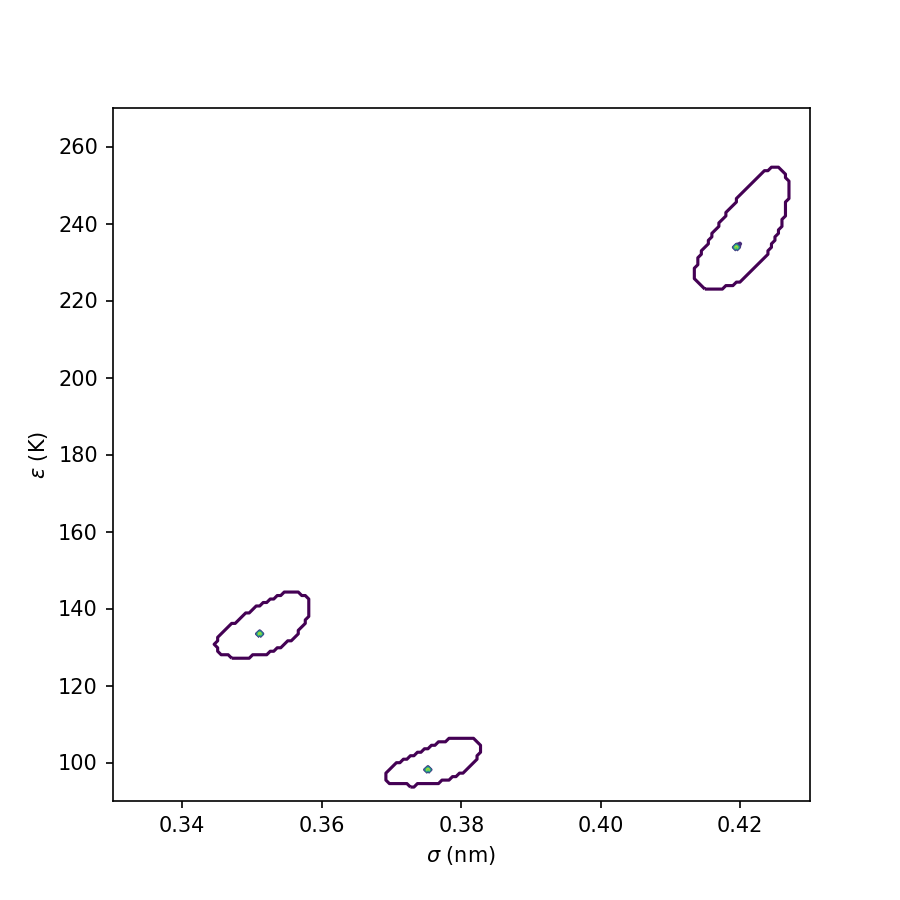

In [26]:
### Performs a 2-dimensional scan and integration of parameter space
### Difference between the integrated log posteriors yields the Bayes factor for model selection

twoD_scan = True
neps = 200
nsig = 200
scan_method = 0 #Method = 0, all scans use same region, Method = 1, scans use zoomed in region (should be more accurate)

model_list = [0,1,2]

eps_low = {0:232,1:97,2:133}
eps_high = {0:240,1:101,2:136.5}
sig_low = {0:0.4185,1:0.3745,2:0.3505}
sig_high = {0:0.4215,1:0.377,2:0.3527}

logp_scan = {}
logp_sum = {}
logp_opt = {}

for model in model_list: 
    logp_sum[model] = 0
    logp_opt[model] = -1e10

if twoD_scan:

    if scan_method == 0:
        
        eps_scan = np.linspace(90,270,neps)
        sig_scan = np.linspace(0.33,0.43,nsig)
        
        for model in model_list: logp_scan[model] = np.zeros([neps,nsig])
    
        for ieps, eps in enumerate(eps_scan):
            
            for isig, sig in enumerate(sig_scan):
        
                for model in model_list:
                
                    logp = calc_posterior(model,eps,sig)
                    
                    logp_scan[model][ieps,isig] = logp
                    
                    logp_sum[model] += logp
                            
                    if logp > logp_opt[model]:
                            
                        logp_opt[model] = logp

    elif scan_method == 1:
        
        logp_scan = {0:[],1:[],2:[]}
        eps_scan = {0:[],1:[],2:[]}
        sig_scan = {0:[],1:[],2:[]}
        
        deps = 0.05
        dsig = 0.00005
       
        for model in model_list:
            
            neps = int((eps_high[model] - eps_low[model])/deps)
            nsig = int((sig_high[model] - sig_low[model])/dsig)
            
            eps_scan[model] = np.linspace(eps_low[model],eps_high[model],neps)
            sig_scan[model] = np.linspace(sig_low[model],sig_high[model],nsig)
            
            logp_scan[model] = np.zeros([neps,nsig])

            for ieps, eps in enumerate(eps_scan[model]):
                
                for isig, sig in enumerate(sig_scan[model]):
                    
                    logp = calc_posterior(model,eps,sig)
                        
                    logp_scan[model][ieps,isig] = logp
                    
                    logp_sum[model] += logp
                            
                    if logp > logp_opt[model]:
                            
                        logp_opt[model] = logp

### Combine the probabilities relative to the overall optimal
prob_model = {0:[],1:[],2:[]}
prob_model_total = {0:[],1:[],2:[]}
prob_normal_model = 0

for model in model_list:
    
    prob_model[model] = np.exp(logp_scan[model] - logp_opt[model])

    prob_normal_model += np.nansum(prob_model[model])

for model in model_list:
    
    prob_model[model] /= prob_normal_model
              
    prob_model_total[model] = np.nansum(prob_model[model])

print('The relative probabilities of each model are: ')
print(prob_model_total)

if scan_method == 0:

    f = plt.figure(figsize=[6,6])
    
    for model in model_list:
        
        plt.contour(sig_scan,eps_scan,prob_model[model])
    plt.xlabel(r'$\sigma$ (nm)')
    plt.ylabel(r'$\epsilon$ (K)')
    plt.show()
    
elif scan_method == 1:

    for model in model_list:
        f = plt.figure(figsize=[6,6])
        CS = plt.contour(sig_scan[model],eps_scan[model],prob_model[model])
        plt.clabel(CS, inline=1, fontsize=10)
        plt.colorbar(CS)
        plt.xlabel(r'$\sigma$ (nm)')
        plt.ylabel(r'$\epsilon$ (K)')
        plt.show()


In [17]:
def RJMC_tuned(calc_posterior,n_iterations, initial_values, prop_var, 
                     tune_for=None, tune_interval=1):
    
    n_params = len(initial_values) #One column is the model number
            
    # Initial proposal standard deviations
    prop_sd = prop_var
    
    # Initialize trace for parameters
    trace = np.zeros((n_iterations+1, n_params)) #n_iterations + 1 to account for guess
    logp_trace = np.zeros(n_iterations+1)
    # Set initial values
    trace[0] = initial_values

    # Initialize acceptance counts
    accepted = [0]*n_params
    rejected = [0]*n_params
               
    model_swaps = 0
    model_swap_attempts = 0
    swap_freq = 1
    
    # OCM: Currently attempting a model swap every single move, although this can be easily changed.  This is something that is not of critical importance now but will be important in the future.
    
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    logp_trace[0] = current_log_prob
    #OCM: This is just the priors at this point.
    
    if tune_for is None:
        tune_for = n_iterations/2
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration '+str(i))
    
        # Grab current parameter values
        current_params = trace[i].copy()
        trace[i+1] = current_params.copy() #Initialize the next step with the current step. Then update if MCMC move is accepted
        current_model = int(current_params[0])
        logp_trace[i+1] = current_log_prob.copy()
        
        # Loop through model parameters
        
        for j in range(n_params):
    
            # Get current value for parameter j
            params = current_params.copy() # This approach updates previous param values
            
            # Propose new values
            if j == 0: #If proposing a new model
                if not i%swap_freq:
                    mod_ran = np.random.random()
                    if mod_ran < 1./3: #Use new models with equal probability
                        proposed_model = 0
                    elif mod_ran < 2./3:
                        proposed_model = 1
                    elif mod_ran < 1:
                        proposed_model = 2
                    if proposed_model != current_model:
                        model_swap_attempts += 1
                        params[0] = proposed_model
                        params[1] *= Tmatrix_eps[current_model,proposed_model]
                        params[2] *= Tmatrix_sig[current_model,proposed_model]
            else:        
                params[j] = rnorm(current_params[j], prop_sd[j])
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*params)
    
            # Log-acceptance rate
            alpha = (proposed_log_prob - current_log_prob) + np.log(Tmatrix_eps[current_model,proposed_model]) + np.log(Tmatrix_sig[current_model,proposed_model])
            
            #OCM:  The two components of the acceptance ratio here are the log of the ratio of the probabilities, and the log of the jacobian determinant between the model spaces
 
            # Sample a uniform random variate (urv)
            urv = runif()
    
            # Test proposed value
            if np.log(urv) < alpha:
                
                # Accept
                trace[i+1] = params
                logp_trace[i+1] = proposed_log_prob.copy()
                current_log_prob = proposed_log_prob.copy()
                current_params = params
                accepted[j] += 1
                if j == 0:
                    if proposed_model != current_model:
                        model_swaps += 1
                        
            else:
                # Reject
                rejected[j] += 1
            
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for) and j != 0:

                acceptance_rate = (1.*accepted[j])/tune_interval             
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1                  

                #print(prop_sd[j])
                accepted[j] = 0              

    accept_prod = np.array(accepted)/(np.array(accepted)+np.array(rejected))                    

    print('Proposed standard deviations are: '+str(prop_sd))
                
    return trace, trace[tune_for:], logp_trace, logp_trace[tune_for:],accept_prod, model_swaps


In [18]:
# Set the number of iterations to run RJMC and how long to tune for
n_iter = 20000 # 20000 appears to be sufficient
tune_for = 1000 #10000 appears to be sufficient
trace_all,trace_tuned,logp_all,logp_tuned, acc_tuned, model_swaps = RJMC_tuned(calc_posterior, n_iter, guess_0, prop_var=guess_var, tune_for=tune_for)


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Proposed standard deviations are: [1, 0.35840839454147433, 0.00017993546723968912]


In [19]:
# Converts the array with the model number into counts of each model type
model_params = trace_all[tune_for:,0]

model_count = np.array([len(model_params[model_params==0]),len(model_params[model_params==1]),len(model_params[model_params==2])])


In [20]:

print('Acceptance Rate during production for eps, sig: '+str(acc_tuned[1:]))

print('Acceptance model swap during production: '+str(model_swaps/(n_iter-tune_for)))

prob_0 = 1.*model_count[0]/(n_iter-tune_for)
print('Percent that single site LJ model is sampled: '+str(prob_0 * 100.)) #The percent that use 1 parameter model

prob_1 = 1.*model_count[1]/(n_iter-tune_for)
print('Percent that two-center UA LJ model is sampled: '+str(prob_1 * 100.)) #The percent that use two center UA LJ
     
prob_2 = 1.*model_count[2]/(n_iter-tune_for)
print('Percent that two-center AUA LJ model is sampled: '+str(prob_2 * 100.)) #The percent that use two center AUA LJ

print('The relative probabilities of each model from direct two-dimensional integration are: ')
print(prob_model_total)

Acceptance Rate during production for eps, sig: [0.44226725 0.50515305]
Acceptance model swap during production: 0.3452631578947368
Percent that single site LJ model is sampled: 56.184210526315795
Percent that two-center UA LJ model is sampled: 35.56842105263158
Percent that two-center AUA LJ model is sampled: 8.25263157894737
The relative probabilities of each model from direct two-dimensional integration are: 
{0: 0.3545813781458194, 1: 0.3227114832673728, 2: 0.32270713858680783}


<IPython.core.display.Javascript object>


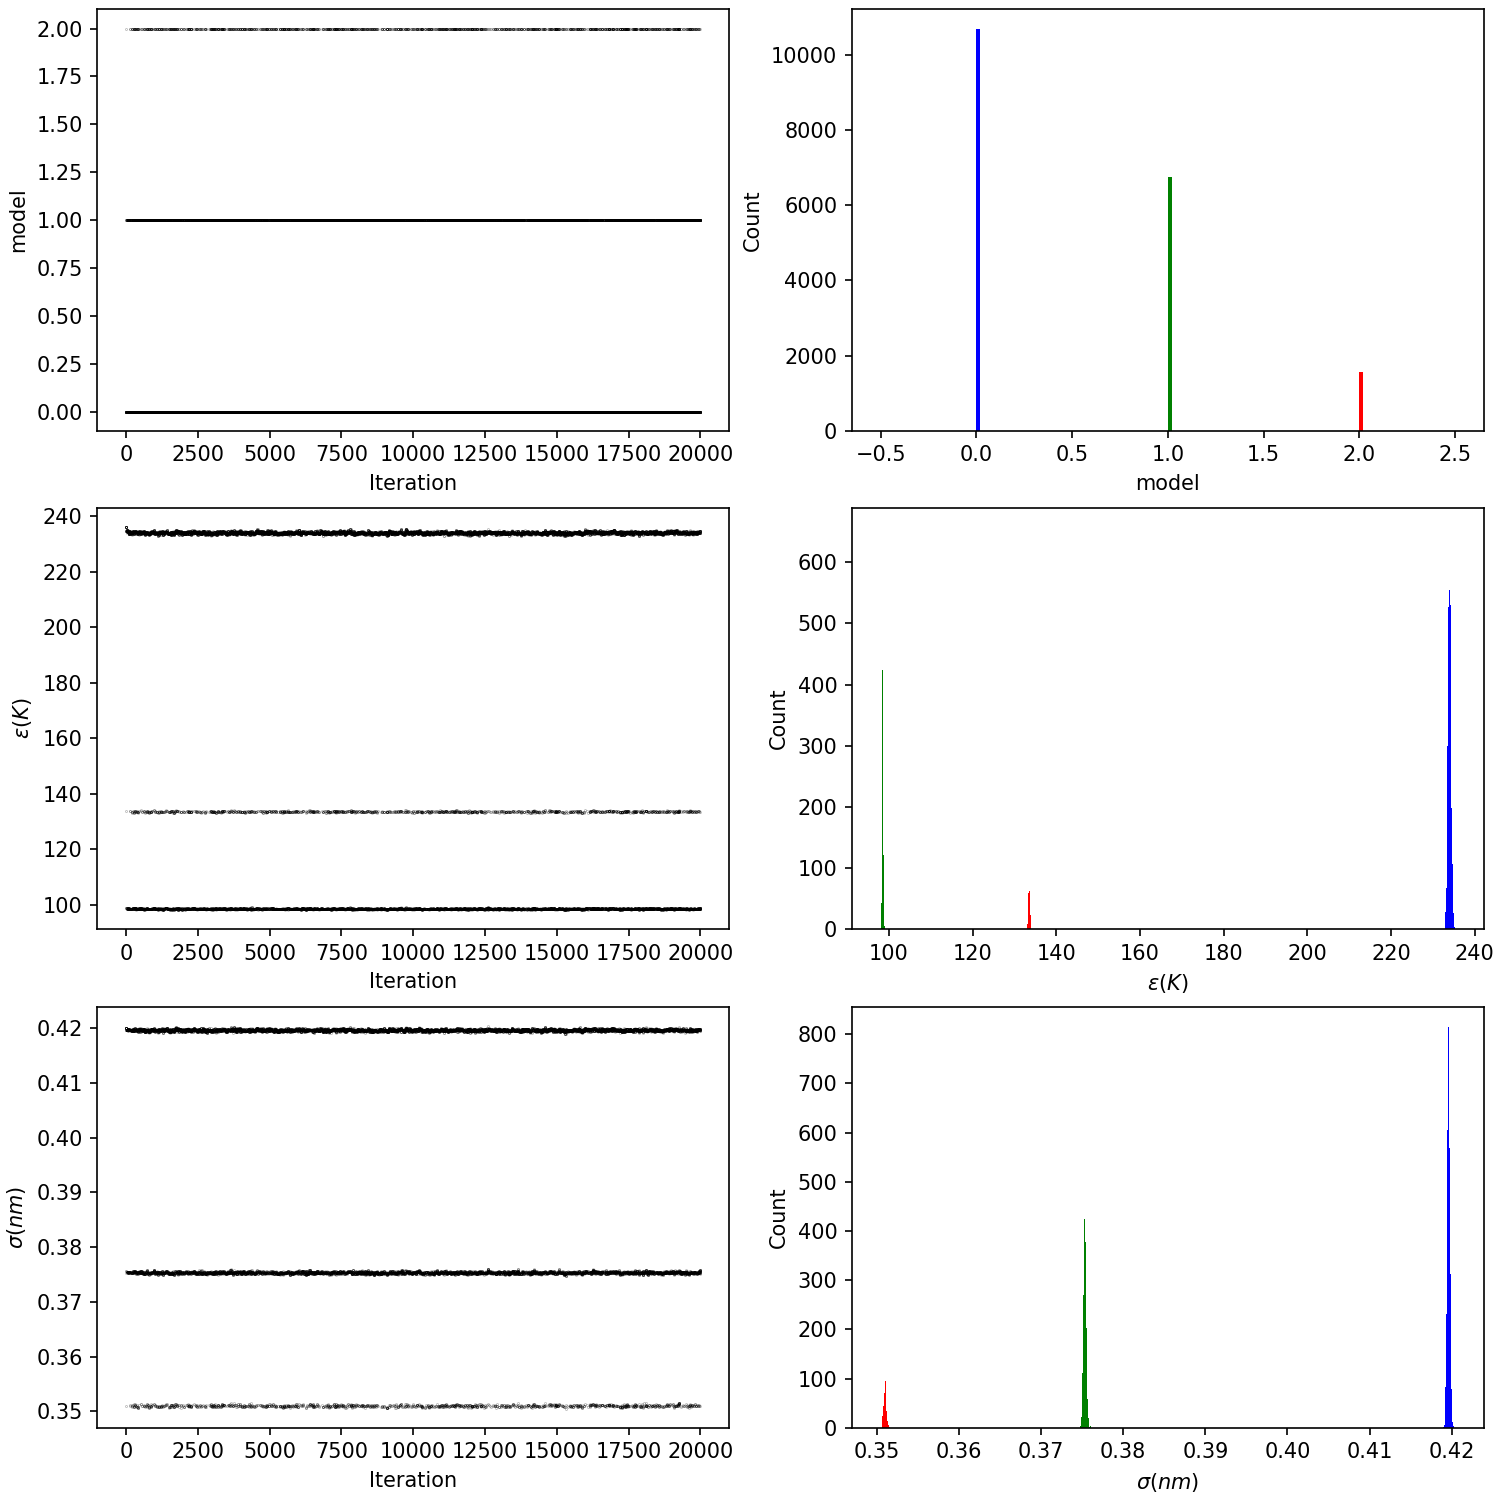

In [21]:
# Create plots of the Markov Chain values for epsilon, sigma, and precision     
f, axes = plt.subplots(3, 2, figsize=(10,10))     
for param, samples, samples_tuned, iparam in zip(['model','$\epsilon (K)$', '$\sigma (nm)$'], trace_all.T,trace_tuned.T, [0,1,2]):
    axes[iparam,0].plot(samples,'ko',markersize=0.1,mfc='None')
    axes[iparam,0].set_ylabel(param)
    axes[iparam,0].set_xlabel('Iteration')
    axes[iparam,1].hist(samples_tuned[model_params==0],bins=50,color='b')
    axes[iparam,1].hist(samples_tuned[model_params==1],bins=50,color='g')
    axes[iparam,1].hist(samples_tuned[model_params==2],bins=50,color='r')
    axes[iparam,1].set_xlabel(param)
    axes[iparam,1].set_ylabel('Count')
    
plt.tight_layout(pad=0.2)


<IPython.core.display.Javascript object>


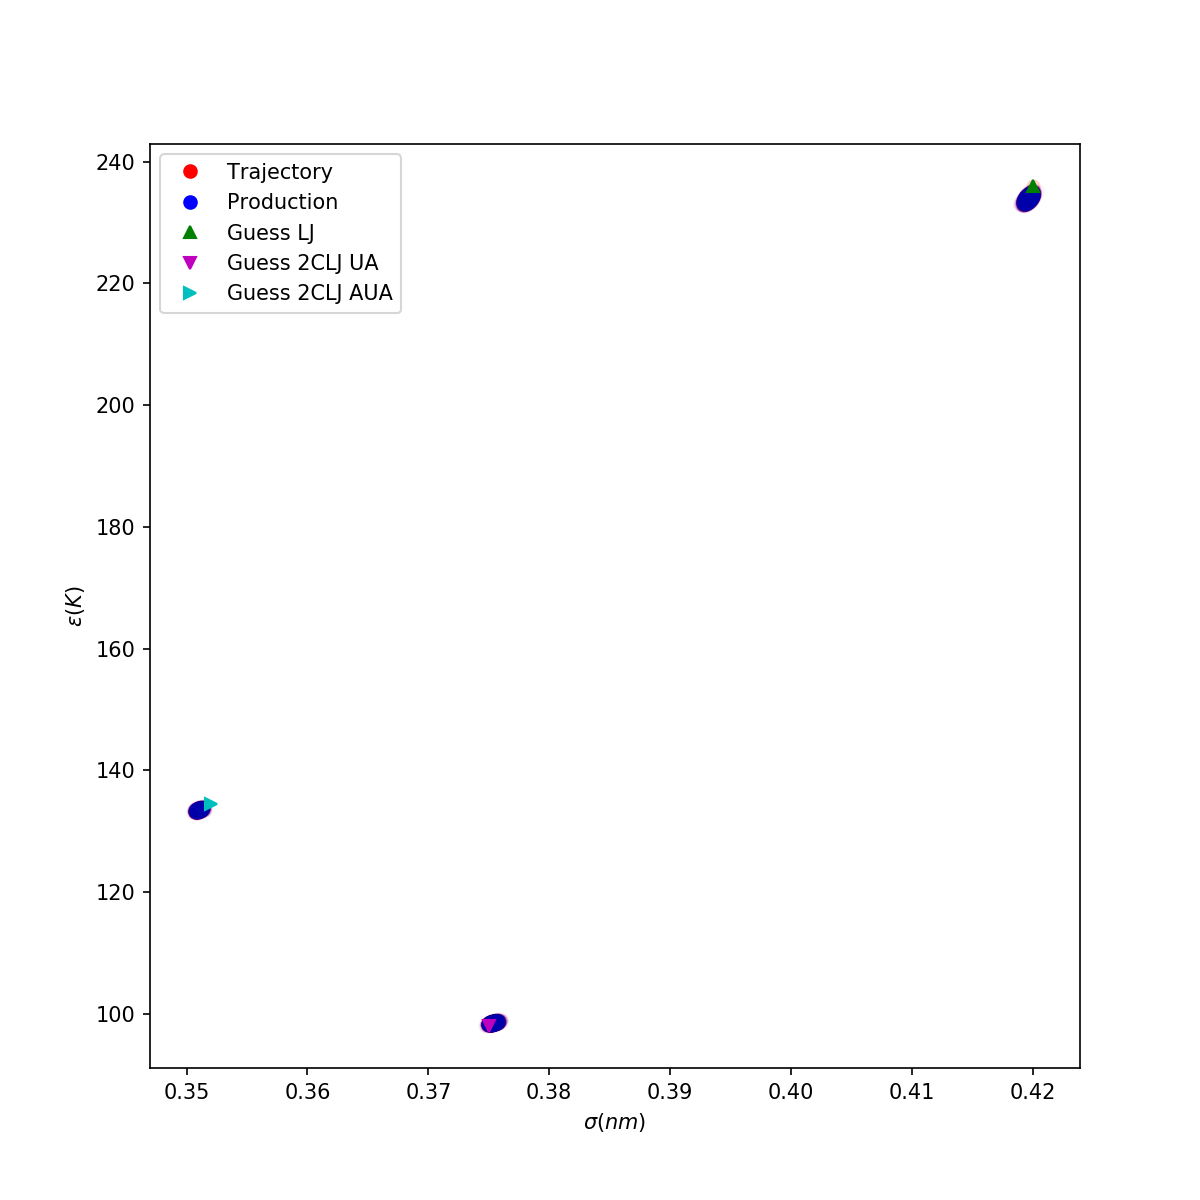

In [22]:
# Plot the eps and sig parameters that are sampled and compare with and guess values
f = plt.figure(figsize=[8,8])
plt.plot(trace_all[:,2],trace_all[:,1],'ro',alpha=0.01)
plt.plot(trace_tuned[:,2],trace_tuned[:,1],'bo',alpha=0.01)
plt.plot([],[],'ro',label='Trajectory')
plt.plot([],[],'bo',label='Production')
plt.plot(guess_0[2],guess_0[1],'g^',label='Guess LJ')
plt.plot(guess_1[2],guess_1[1],'mv',label='Guess 2CLJ UA')
plt.plot(guess_2[2],guess_2[1],'c>',label='Guess 2CLJ AUA')
plt.xlabel('$\sigma (nm)$')
plt.ylabel('$\epsilon (K)$')
plt.legend()


<IPython.core.display.Javascript object>


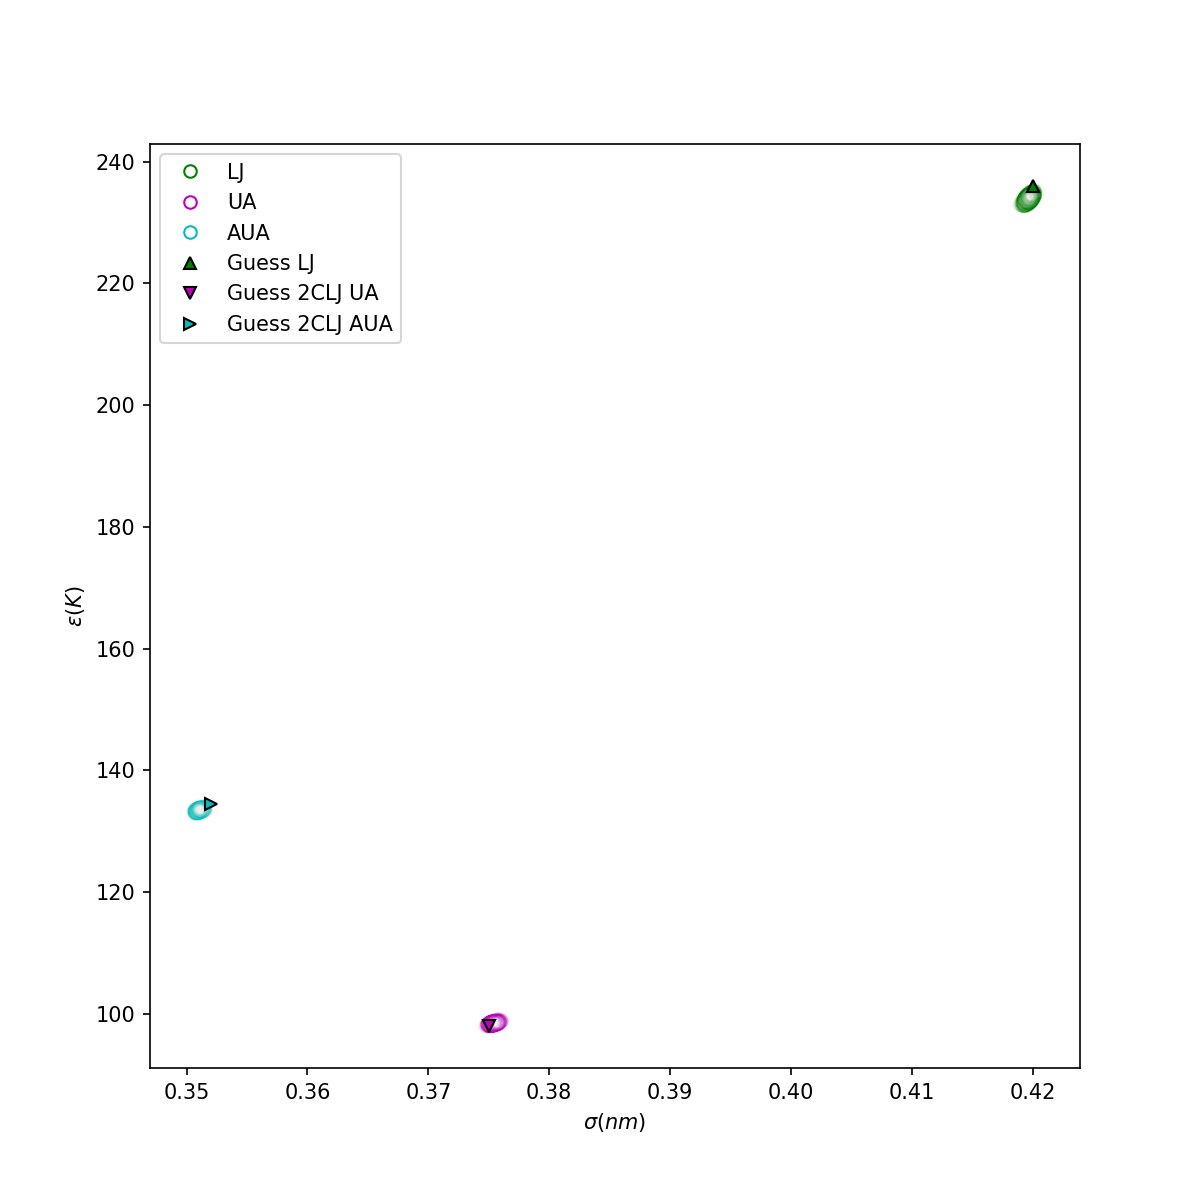

In [23]:
trace_0=[]
trace_1=[]
trace_2=[]
for i in range(np.size(trace_tuned,0)):
    if trace_tuned[i,0]==0:
        trace_0.append(trace_tuned[i])
    elif trace_tuned[i,0]==1:
        trace_1.append(trace_tuned[i])
    elif trace_tuned[i,0]==2:
        trace_2.append(trace_tuned[i])

trace_0=np.asarray(trace_0)
trace_1=np.asarray(trace_1)
trace_2=np.asarray(trace_2)

f = plt.figure(figsize=[8,8])
if len(trace_0) > 0: plt.plot(trace_0[:,2],trace_0[:,1],'go',alpha=0.05,mfc='w')
if len(trace_1) > 0: plt.plot(trace_1[:,2],trace_1[:,1],'mo',alpha=0.05,mfc='w')
if len(trace_2) > 0: plt.plot(trace_2[:,2],trace_2[:,1],'co',alpha=0.05,mfc='w')

plt.plot([],[],'go',label='LJ',mfc='w')
plt.plot([],[],'mo',label='UA',mfc='w')
plt.plot([],[],'co',label='AUA',mfc='w')

plt.plot(guess_0[2],guess_0[1],'g^',markeredgecolor='k',label='Guess LJ')
plt.plot(guess_1[2],guess_1[1],'mv',markeredgecolor='k',label='Guess 2CLJ UA')
plt.plot(guess_2[2],guess_2[1],'c>',markeredgecolor='k',label='Guess 2CLJ AUA')
    
plt.xlabel('$\sigma (nm)$')
plt.ylabel('$\epsilon (K)$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


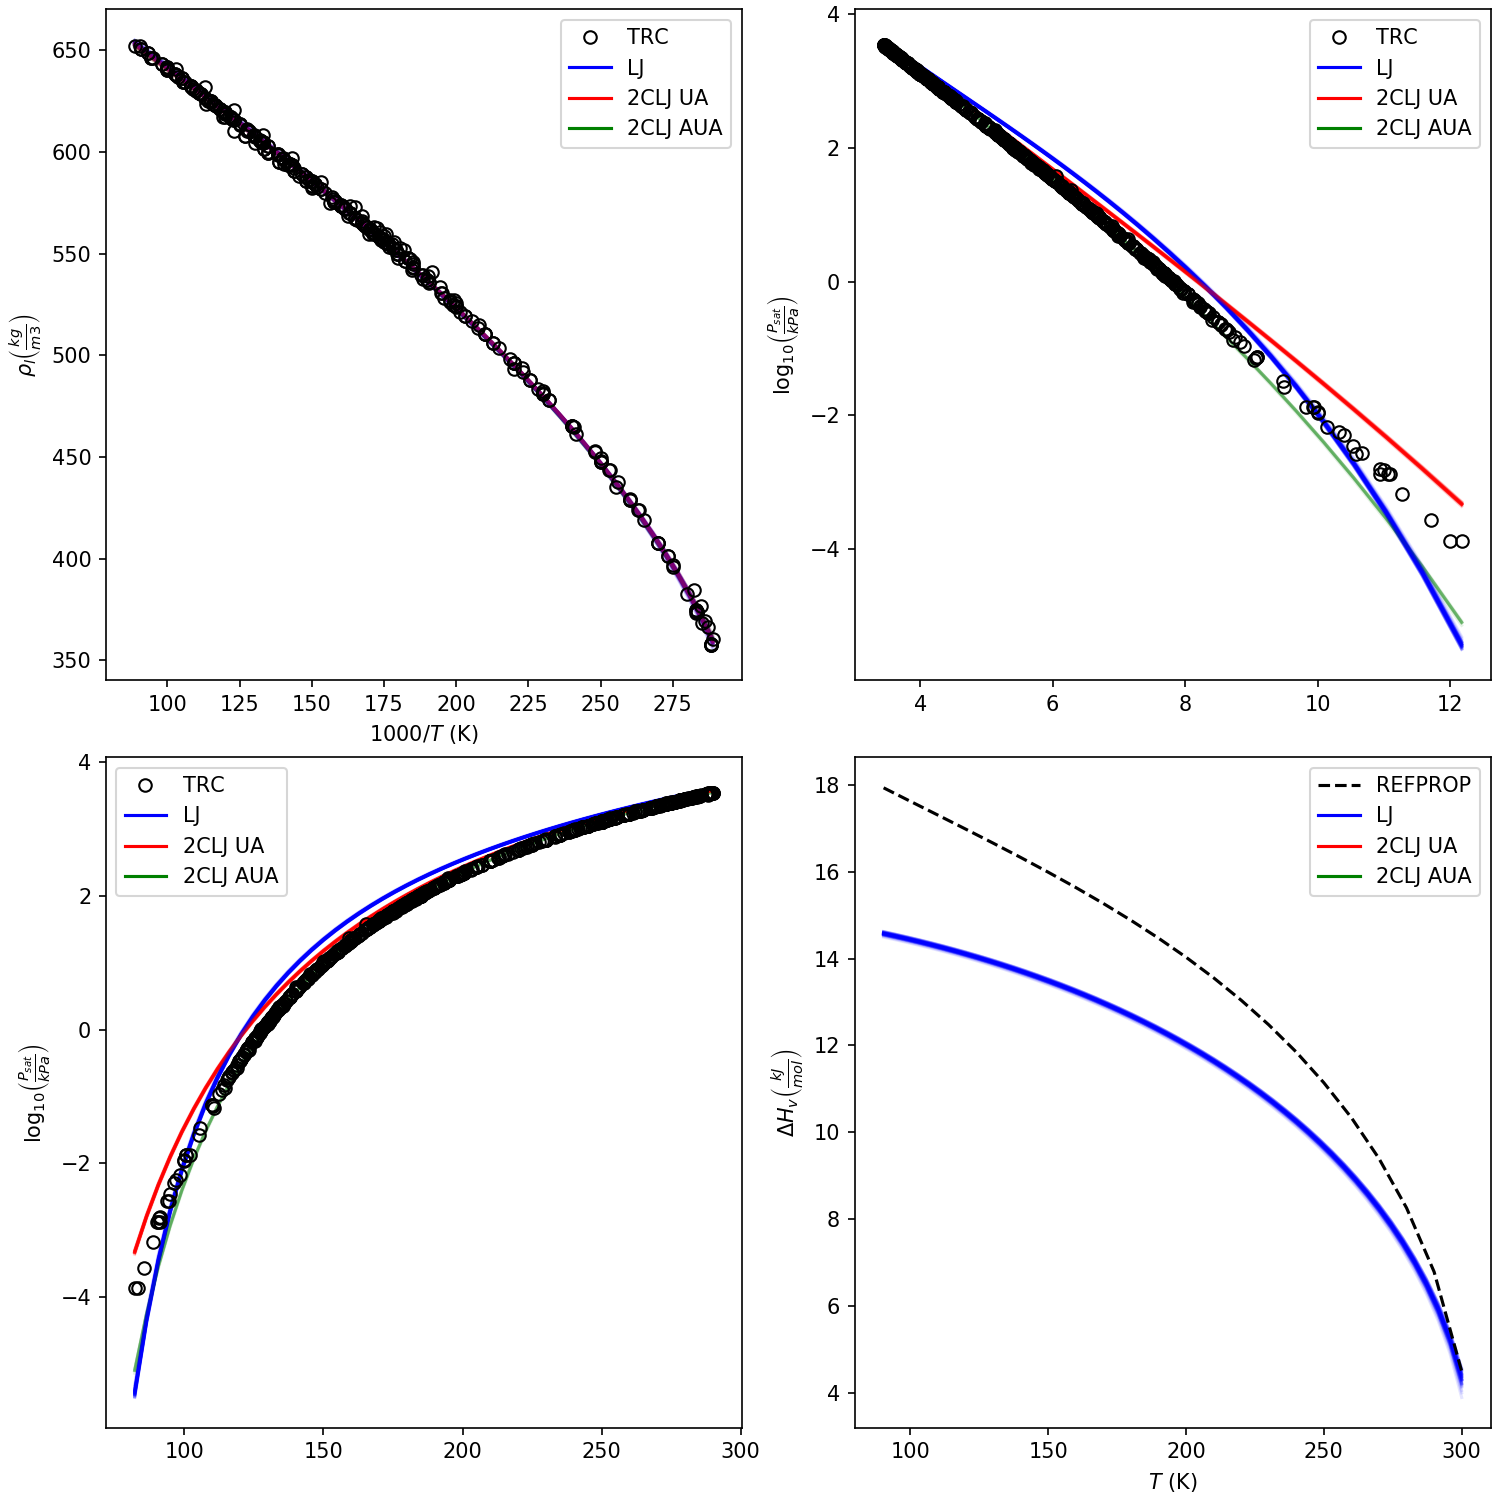

In [24]:
T_plot_deltaHv = np.linspace(T_deltaHv.min(), T_deltaHv.max())
T_plot_rhol = np.linspace(T_rhol_data.min(), T_rhol_data.max())
T_plot_Psat = np.linspace(T_Psat_data.min(), T_Psat_data.max())
   
# Plot the predicted properties versus REFPROP. Include the Bayesian uncertainty by sampling a subset of 100 eps/sig.
f, axarr = plt.subplots(2,2,figsize=(10,10))

color_scheme = ['b','r','g']
labels = ['LJ','2CLJ UA','2CLJ AUA']
xlabels = ['$T$ (K)','$T$ (K)','$1000/T$ (K)','$T$ (K)']

for i in range(100): #Plot 100 random samples from production
    model_sample, eps_sample, sig_sample = trace_tuned[np.random.randint(0, n_iter - tune_for)]
    model_sample = int(model_sample)
    if model_sample == 0:
        deltaHv_sample = Ethane_LJ.deltaHv_hat_LJ(T_plot_deltaHv,eps_sample)
        axarr[1,1].plot(T_plot_deltaHv,deltaHv_sample,color_scheme[model_sample],alpha=0.1)
    rhol_sample = rhol_hat_models(T_plot_rhol,model_sample,eps_sample,sig_sample)
    Psat_sample = Psat_hat_models(T_plot_Psat,model_sample,eps_sample,sig_sample)

    axarr[0,0].plot(T_plot_rhol,rhol_sample,color_scheme[model_sample],alpha=0.1)
    axarr[1,0].plot(T_plot_Psat,np.log10(Psat_sample),color_scheme[model_sample],alpha=0.1)
    axarr[0,1].plot(1000./T_plot_Psat,np.log10(Psat_sample),color_scheme[model_sample],alpha=0.1) 

axarr[0,0].plot(T_rhol_data,rhol_data,'ko',mfc='None',label='TRC')
axarr[1,0].plot(T_Psat_data,np.log10(Psat_data),'ko',mfc='None',label='TRC')
axarr[0,1].plot(1000./T_Psat_data,np.log10(Psat_data),'ko',mfc='None',label='TRC')
axarr[1,1].plot(T_deltaHv,RP_deltaHv,'k--',label='REFPROP')

for axrow in axarr:
    for ax in axrow:
        for col, lab in zip(color_scheme,labels):
            ax.plot([],[],col,label=lab)
        ax.legend()
    
axarr[0,0].set_xlabel("$T$ (K)")
axarr[0,0].set_ylabel(r"$\rho_l \left(\frac{kg}{m3}\right)$")

axarr[0,0].set_xlabel("$T$ (K)")
axarr[1,0].set_ylabel(r"$\log_{10}\left(\frac{P_{sat}}{kPa}\right)$")

axarr[0,0].set_xlabel("$1000/T$ (K)")
axarr[0,1].set_ylabel(r"$\log_{10}\left(\frac{P_{sat}}{kPa}\right)$")

axarr[1,1].set_xlabel("$T$ (K)")
axarr[1,1].set_ylabel(r"$\Delta H_v \left(\frac{kJ}{mol}\right)$")

plt.tight_layout(pad=0.2)
plt.show()

19001